In [1]:
# modify these addresses as needed
from utils import local_ip
proxy_addr = ('128.110.216.104', 4433)
echo_addr = ('128.110.216.130', 12345)
# local_addr is assigned dynamically

'''
Run echo server on a machine with Python and public IP address:

cd ~
rm -rf ~/masque-linux
sudo git clone https://github.com/dx2102/masque-linux
cd ~/masque-linux
sudo chmod a+rwx -R .
clear
python3 echo_server.py
(or python3 echo_server.py --quiet)




Run masquerade on a linux x86 machine with public IP address:
rm -rf ~/masque-linux
sudo git clone https://github.com/dx2102/masque-linux
cd ~/masque-linux
sudo chmod a+rwx -R .
clear

ifconfig -a
export RUST_LOG=debug
./server 0.0.0.0:4433
'''
None

In [2]:
import time
import os
import queue
import threading
import socket
import random

import asyncio
def loop():
    return asyncio.get_event_loop()
import aioquic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from utils import start

In [3]:
def benchmark(
        send_queue, recv_queue, experiment_name = 'experiment',
        payload = '', n = 100, gap = 0.01
    ):
    '''
    Benchmark any Connection object.
    Concatenate current time and a space to data, and send it n times.
    Record delays of each packet.
    Plot the result and save data to ./results/experiment_name.csv
    '''
    send_time = [None] * n
    recv_time = [None] * n
    @start
    def recv():
        for _ in range(n):
            data = recv_queue.get().decode()
            # split with the first space
            index, data = data.split(' ', 1)
            index = int(index)
            recv_time[index] = time.time()
    @start
    def send():
        for index in range(n):
            send_time[index] = time.time()
            data = (str(index) + ' '+ payload).encode()
            send_queue.put(data)
            time.sleep(gap)

    # only wait until send is done, then wait for 0.5 seconds
    # all packets that have not arrived will be assumed lost
    start_time = time.time()
    send.join()
    end_time = time.time()
    print(f'sending {n} packets with gap {gap} took {end_time - start_time} seconds')
    time.sleep(0.5)

    if not os.path.exists('./results'):
        os.makedirs('./results')

    # csv
    send_time = np.array(send_time)
    recv_time = np.array(recv_time)
    df = pd.DataFrame({
        'send_time': send_time,
        'recv_time': recv_time,
    })
    df.to_csv(f'./results/{experiment_name}.csv')
    
    # plot delays, red spots are lost packets
    df['delay'] = df['recv_time'] - df['send_time']
    df['delay'].plot()
    # red spots at y=0
    plt.scatter(
        df[df['delay'].isnull()].index,
        np.zeros(df['delay'].isnull().sum()),
        color='red', s=3
    )
    plt.xlabel('packet index')
    plt.ylabel('delay (s)')
    plt.title(experiment_name)
    plt.show()
    plt.savefig(f'./results/{experiment_name}.png')


sending 100 packets with gap 0 took 0.0 seconds


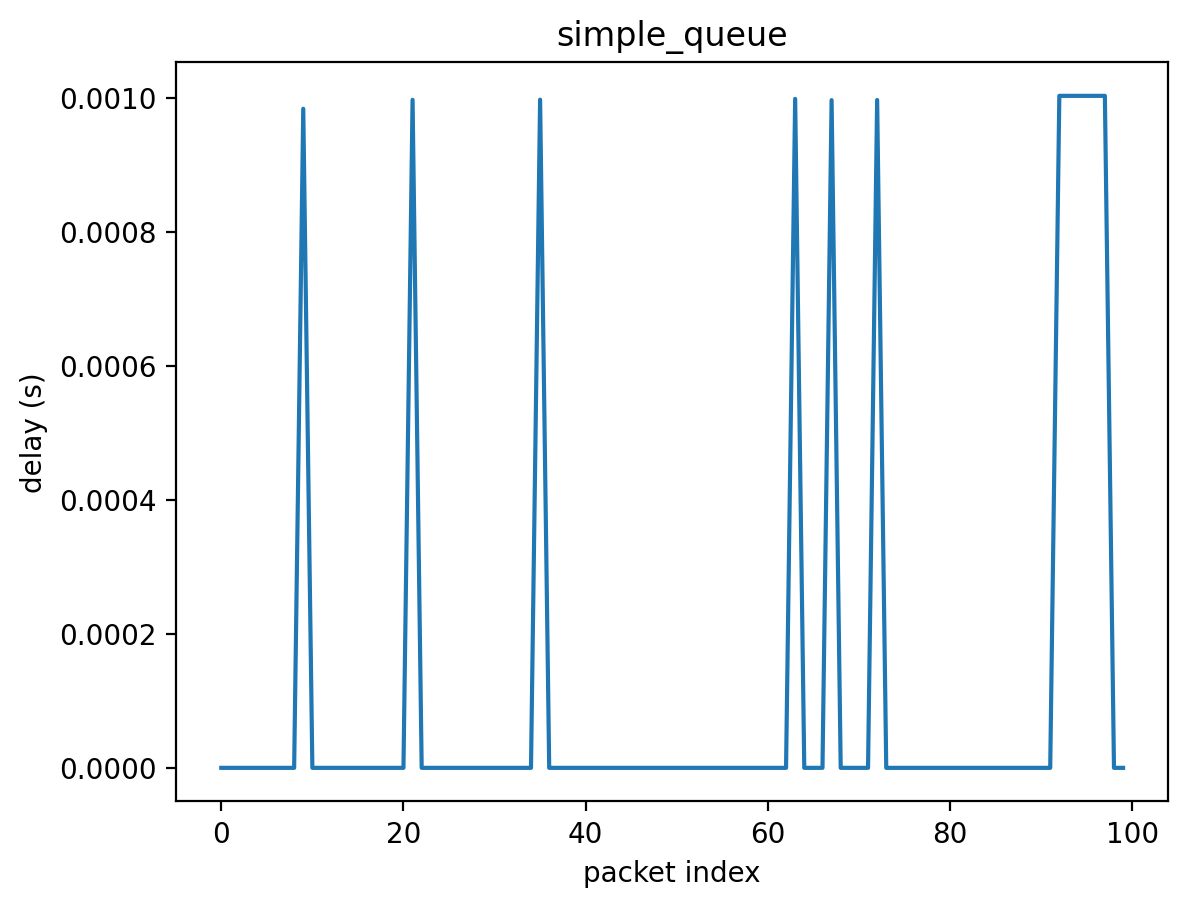

<Figure size 640x480 with 0 Axes>

In [4]:
name = 'simple_queue'
q = queue.Queue()
benchmark(
    q, q, name,
    payload='hello world', 
    n=100, gap=0,
)

('128.110.216.130', 12345)


sending 10 packets with gap 0 took 0.0 seconds


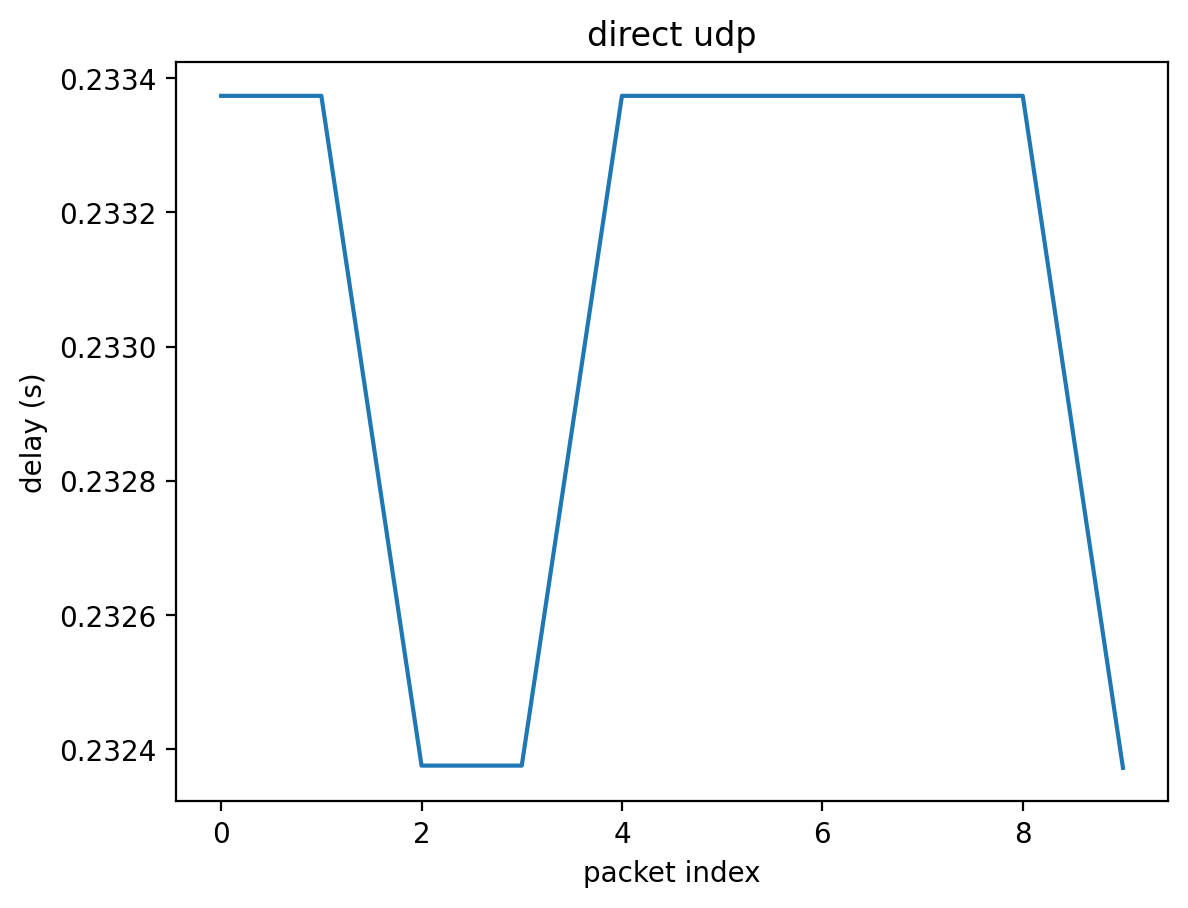

<Figure size 640x480 with 0 Axes>

In [5]:
name = 'direct udp'
send_queue = queue.Queue()
recv_queue = queue.Queue()
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
print(echo_addr)
sock.bind(('', 0))
@start
def recv():
    while True:
        data, addr = sock.recvfrom(1024)
        recv_queue.put(data)
@start
def send():
    while True:
        data = send_queue.get()
        sock.sendto(data, echo_addr)
benchmark(
    send_queue, recv_queue, name,
    payload='direct udp hello world', 
    n=10, gap=0,
)


sending 10 packets with gap 0 took 0.0 seconds


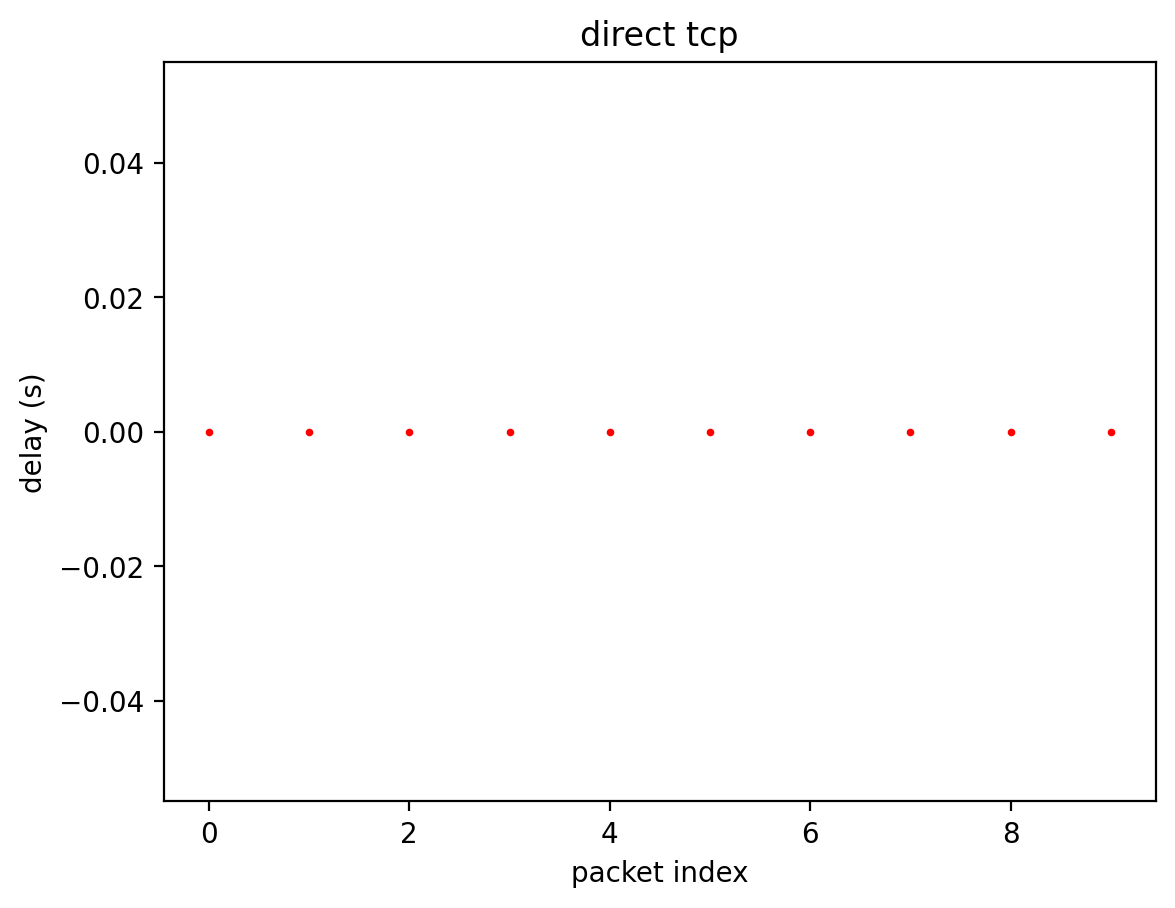

<Figure size 640x480 with 0 Axes>

In [6]:
name = 'direct tcp'
send_queue = queue.Queue()
recv_queue = queue.Queue()
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(echo_addr)
@start
def recv():
    buffer = []
    while True:
        data = sock.recv(1024)
        if not data:
            break
        buffer.append(data)
        if b'\n' in data:
            data = b''.join(buffer)
            buffer = []
            recv_queue.put(data)
@start
def send():
    while True:
        data = send_queue.get()
        sock.send(data + b'\n')
benchmark(
    send_queue, recv_queue, name,
    payload='direct tcp hello world', 
    n=10, gap=0,
)


masque client started. Now trying handshake
ProtocolNegotiated(alpn_protocol='h3-29')
HandshakeCompleted(alpn_protocol='h3-29', early_data_accepted=False, session_resumed=False)
Connected
ConnectionIdIssued(connection_id=b'\xcd\xbeW>$\x8f\xc1\xe0')
StreamDataReceived(data=b'\xcd\x16D\x0f\x03q\xcd\x15\x00\xda\x13\xa4h\x99\xdd\x84\x8b\x12GREASE is the word\x01\x03\x00\x00\xd9', end_stream=False, stream_id=0)
sending 10 packets with gap 1e-07 took 0.049002647399902344 seconds


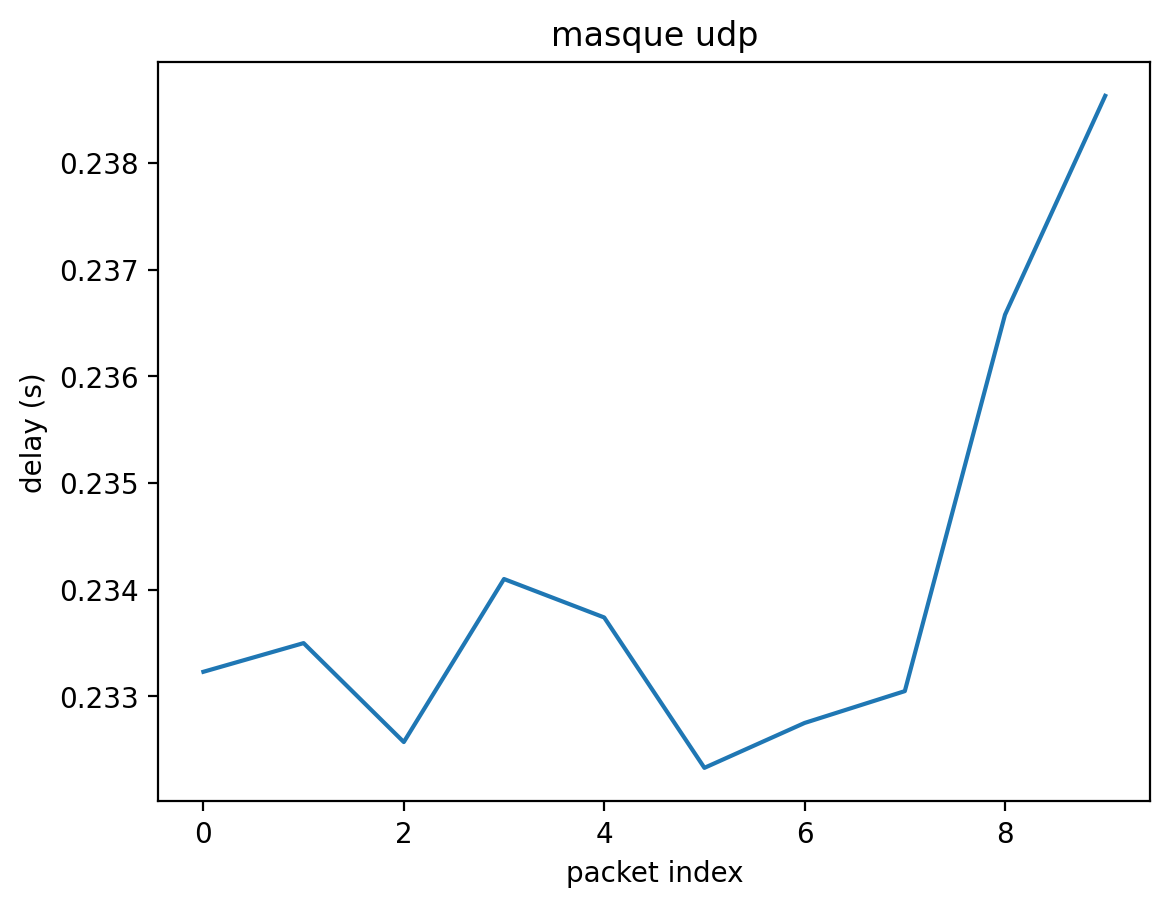

ConnectionTerminated(error_code=<QuicErrorCode.NO_ERROR: 0>, frame_type=None, reason_phrase='')


<Figure size 640x480 with 0 Axes>

In [7]:

name = 'masque udp'

import ssl

from aioquic.quic.connection import QuicConnection
from aioquic.quic.configuration import QuicConfiguration
from aioquic.h3.connection import H3Connection
from aioquic.quic.events import QuicEvent

from aioquic.asyncio.client import connect
from aioquic.asyncio.protocol import QuicConnectionProtocol

send_queue = queue.Queue()
recv_queue = queue.Queue()

masque_headers=[
    (b":method", b"CONNECT"), 
    # CONNECT is a special marker in HTTP protocol. 
    # It means we want proxy instead of normal GET/POST request.
    
    (b":protocol", b"connect-udp"), 
    # unique in masquerade, use UDP instead of TCP
    
    (b":path", f"/well-known/masque/{echo_addr[0]}/{echo_addr[1]}".encode()), 
    # destination address and port. MASQUE server should define the URL template. 
    # The masquerade Rust script just reads the last two items of the path.

    (b":authority", b"localhost"), 
    # Address of the proxy server itself, not checked by masquerade

    (b":scheme", b"https"), 
    # scheme allows mixing http and https in the same connection, not checked by masquerade
]


configuration=QuicConfiguration(
    is_client=True,
    verify_mode=ssl.CERT_NONE, 
    alpn_protocols=["h3-29"], 
    max_datagram_frame_size=1200,                  
)

# We use aioquic connect method to create UDP socket and QUIC connection,
# but anually managing the state machine of self.h3.
# so we must ensure that self.h3 receives all QuicEvents.


class MasqueClient(QuicConnectionProtocol):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.h3 = H3Connection(self._quic)

    def quic_event_received(self, event: QuicEvent):
        self.h3.handle_event(event)
        sort = event.__class__.__name__
        if sort == 'StreamDataReceived':
            if event.stream_id % 4 == 3:
                # print('drop GREASE noise on stream', event.stream_id)
                return
        if sort == 'DatagramFrameReceived':
            data = event.data[2:]
            recv_queue.put(data)
            return
        print(event)

print("masque client started. Now trying handshake")
async with connect(
    *proxy_addr,
    create_protocol=MasqueClient,
    configuration=configuration,
) as client:
    print("Connected")
    stream_id = client._quic.get_next_available_stream_id()
    client.h3.send_headers(
        stream_id=stream_id,
        headers=masque_headers,
    )
    client.transmit()
    # wait for 200 OK. For simplicity, we just wait for 0.5 second.
    time.sleep(0.5)
    flow_id = stream_id // 4
    async def send():
        while True:
            data = await loop().run_in_executor(None, send_queue.get)
            client.h3.send_datagram(flow_id, b'\x00' + data)
            client.transmit()
    asyncio.create_task(send())
    await loop().run_in_executor(None, lambda: benchmark(
        send_queue, recv_queue, name,
        payload='masque udp hello world', 
        n=10, gap=0.0000001,
    ))
    



